# CID_SID ML model for TDP1 inhibitors


### Content   <a name="content"></a>

1. [Load and analyse PubChem BioAssay data](#1)
2. [Create a data frame with CIDs and targets](#2)
3. [Reduce the inactive compounds](#3)
4. [Ensure equal number of both targets](#4)
5. [Balancing](#5)
6. [Machine Learning](#6)
7. [Cross-validation](#7)
8. [Scrutinize for overfitting](#8)
9. [Hyperparameter tuning with Optuna](#9)
10. [Confusion Matrix and Classification report](#10)

### Load and analyse PubChem BioAssay data <a name="1"></a>

In [1]:
import pandas as pd 

# load the PubChem AID 686978 bioassy dataset
# https://pubchem.ncbi.nlm.nih.gov/bioassay/686978
df = pd.read_csv('AID_686978_data.csv', low_memory=False, on_bad_lines='skip')

# To avoid truncation of some columns during data frame display
pd.set_option('display.max_columns', None) 

# Display the data frame
print('Shape of the data frame: ', df.shape)
df.head()

Shape of the data frame:  (424003, 48)


,PUBCHEM_RESULT_TAG,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,Phenotype,Potency,Efficacy,Analysis Comment,Activity_Score,Curve_Description,Fit_LogAC50,Fit_HillSlope,Fit_R2,Fit_InfiniteActivity,Fit_ZeroActivity,Fit_CurveClass,Excluded_Points,Max_Response,Activity at 0.0000295000 uM,Activity at 0.0000590000 uM,Activity at 0.0001503265 uM,Activity at 0.0002712146 uM,Activity at 0.0005895491 uM,Activity at 0.00117 uM,Activity at 0.00179 uM,Activity at 0.00299 uM,Activity at 0.00672 uM,Activity at 0.014 uM,Activity at 0.026 uM,Activity at 0.040 uM,Activity at 0.074 uM,Activity at 0.167 uM,Activity at 0.363 uM,Activity at 0.628 uM,Activity at 0.975 uM,Activity at 1.849 uM,Activity at 4.119 uM,Activity at 9.037 uM,Activity at 15.83 uM,Activity at 21.08 uM,Activity at 46.23 uM,Activity at 92.54 uM,Activity at 165.6 uM,Compound QC;;;;
0,1,109967258,50897788.0,CNCC1=NC2=C(C=C(C=C2)Cl)C(=N1)C3=CC=CN3,Active,42,http://assay.nih.gov/htsws/rest/display/dd-tdp...,NaN,Inhibitor,14.1254,136.5470,NaN,42.0,Partial curve; high efficacy,-4.850,1.0100,0.9948,-134.4880,2.0597,-2.1,0 0 0 0 0,-106.3110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0597,NaN,NaN,NaN,NaN,0.5007,NaN,NaN,-17.4373,NaN,-48.5138,NaN,NaN,-106.3110,NaN,NaN,QC'd by AA Pharmaceuticals;;;
1,2,144206324,65628.0,CN1C2=C(C=C(C=C2)N(CCCl)CCCl)N=C1CCCC(=O)O,Active,41,http://assay.nih.gov/htsws/rest/display/dd-tdp...,NaN,Inhibitor,18.8375,82.1468,NaN,41.0,Partial curve; high efficacy,-4.725,1.9887,0.9829,-82.6097,-0.4629,-2.1,0 0 0 0 0 0 0 0,-70.9545,NaN,NaN,NaN,NaN,-3.2819,NaN,NaN,1.1641,NaN,5.8554,NaN,NaN,-1.8326,NaN,-4.9853,NaN,NaN,0.0798,NaN,-16.3921,NaN,NaN,-70.9545,NaN,NaN,QC'd by ACC;;;
2,3,144206325,14708.0,C[C@]12CC[C@H]3[C@H]([C@@H]1CC[C@]2(C)O)CC[C@@...,Inconclusive,10,http://assay.nih.gov/htsws/rest/display/dd-tdp...,NaN,Inhibitor,21.1360,39.2903,NaN,10.0,Single point of activity,-4.675,2.7868,0.9357,-43.4549,-4.1646,-3.0,0 0 0 0 0 0 0 0,-39.2270,NaN,NaN,NaN,NaN,-4.1400,NaN,NaN,-5.7369,NaN,0.1681,NaN,NaN,-8.2838,NaN,-6.9258,NaN,NaN,1.0188,NaN,-7.8647,NaN,NaN,-39.2270,NaN,NaN,QC'd by ACC;;;;
3,4,144206326,3085168.0,CC1=NC=C(C(=N1)N)CN(C=O)/C(=C(\CCO)/SS/C(=C(/C...,Inactive,0,http://assay.nih.gov/htsws/rest/display/dd-tdp...,NaN,Inactive,NaN,NaN,NaN,0.0,NaN,NaN,4.9549,0.6177,2.0768,-13.6113,4.0,0 0 0 0 0 0 0 1,-5.7844,NaN,NaN,NaN,NaN,-11.9232,NaN,NaN,-14.5799,NaN,8.2225,NaN,NaN,4.9756,NaN,4.8996,NaN,NaN,-10.1081,NaN,3.3805,NaN,NaN,-5.7844,NaN,NaN,QC'd by ACC;;;;
4,5,144206327,2449.0,CC1=C(C(=O)C(=C(C1=O)C)C(CCCCCC(=O)O)C2=CC=CC=...,Inconclusive,10,http://assay.nih.gov/htsws/rest/display/dd-tdp...,NaN,Inhibitor,26.6086,77.9682,NaN,10.0,Single point of activity,-4.575,3.5117,0.9609,-82.1111,-4.1429,-3.0,0 0 0 0 0 0 0 0,-72.3569,NaN,NaN,NaN,NaN,-10.6429,NaN,NaN,-2.5661,NaN,-11.5870,NaN,NaN,-4.3838,NaN,1.2149,NaN,NaN,1.7567,NaN,-5.8883,NaN,NaN,-72.3569,NaN,NaN,QC'd by ACC;;;;


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424003 entries, 0 to 424002
Data columns (total 48 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   PUBCHEM_RESULT_TAG             424003 non-null  int64  
 1   PUBCHEM_SID                    424003 non-null  int64  
 2   PUBCHEM_CID                    423975 non-null  float64
 3   PUBCHEM_EXT_DATASOURCE_SMILES  423975 non-null  object 
 4   PUBCHEM_ACTIVITY_OUTCOME       424003 non-null  object 
 5   PUBCHEM_ACTIVITY_SCORE         424003 non-null  int64  
 6   PUBCHEM_ACTIVITY_URL           424003 non-null  object 
 7   PUBCHEM_ASSAYDATA_COMMENT      0 non-null       float64
 8   Phenotype                      424003 non-null  object 
 9   Potency                        175189 non-null  float64
 10  Efficacy                       175189 non-null  float64
 11  Analysis Comment               0 non-null       float64
 12  Activity_Score                

In [3]:
# Remive missing values
df = df[df['PUBCHEM_CID'].notna()]
df.shape

(423975, 48)

In [4]:
# Remove duplicates without keeping a sample ofthem and reset the indexes 
df = df.drop_duplicates(subset='PUBCHEM_CID', keep=False).reset_index(drop=True)
df.shape

(410564, 48)

In [5]:
# Turn CID float data type into integer
df['PUBCHEM_CID'] = df['PUBCHEM_CID'].astype('int64') 

In [6]:
# Filter inhibitors 
df = df[['PUBCHEM_CID',
         'PUBCHEM_SID',
         'PUBCHEM_ACTIVITY_OUTCOME']] 
df.shape # 646675

(410564, 3)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410564 entries, 0 to 410563
Data columns (total 3 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   PUBCHEM_CID               410564 non-null  int64 
 1   PUBCHEM_SID               410564 non-null  int64 
 2   PUBCHEM_ACTIVITY_OUTCOME  410564 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.4+ MB


[<a href="#content">Back to top</a>]

## Create a data frame with CIDs and targets <a name="2"></a>

In [8]:
df['PUBCHEM_ACTIVITY_OUTCOME'] = df['PUBCHEM_ACTIVITY_OUTCOME'].astype(str) 
# Get unique values from 'column1'
unique_values = df['PUBCHEM_ACTIVITY_OUTCOME'].unique()
unique_values 

array(['Active', 'Inconclusive', 'Inactive'], dtype=object)

In [9]:
df.rename(columns={'PUBCHEM_CID':'CID',
                   'PUBCHEM_SID':'SID',
                   'PUBCHEM_ACTIVITY_OUTCOME':'target'}, inplace=True)

# Set the option to explicitly handle downcasting
pd.set_option('future.no_silent_downcasting', True)

# Create a mapping dictionary to replace string values with numeric values
mapping = {'Active': 1, 'Inactive': 0, 'Inconclusive':2}

# Replace string values with numeric values using the mapping dictionary
df['target'] = df['target'].replace(mapping)

# Display the data frame
print('Shape of the data frame: ', df.shape)
df.head()

Shape of the data frame:  (410564, 3)


,CID,SID,target
0,50897788,109967258,1
1,65628,144206324,1
2,14708,144206325,2
3,3085168,144206326,0
4,2449,144206327,2


In [10]:
# Turn CID float data type into integer
df['target'] = pd.to_numeric(df['target']) 

In [11]:
df['target'].value_counts()

target
0    236226
2    112867
1     61471
Name: count, dtype: int64

In [12]:
df_1 = df[df['target']==1]
df_1.shape

(61471, 3)

[<a href="#content">Back to top</a>]

## Reduce the inactive compounds <a name="3"></a>

In [13]:
# load the water solunility data 
df_sol = pd.read_csv('AID_1996_data.csv')

# Display the data frame
print('Shape of the data frame: ', df_sol.shape)
df_sol.head()

Shape of the data frame:  (57859, 30)


,PUBCHEM_RESULT_TAG,SID,CID,PUBCHEM_EXT_DATASOURCE_SMILES,OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,Solubility at pH 7.4_Qualifier_Mean,Solubility at pH 7.4_Mean,Test Concentration_1,Solubility at pH 7.4_Qualifier_1,Solubility at pH 7.4_1,Solubility at pH 7.4_Comment_1,Solubility of Astemizole at pH 7.4_Qualifier_1,Solubility of Astemizole at pH 7.4_1,Solubility of Sulfamethizole at pH 7.4_Qualifier_1,Solubility of Sulfamethizole at pH 7.4_1,Solubility of Imipramine HCl at pH 7.4_Qualifier_1,Solubility of Imipramine HCl at pH 7.4_1,Test Concentration_2,Solubility at pH 7.4_Qualifier_2,Solubility at pH 7.4_2,Solubility at pH 7.4_Comment_2,Solubility of Astemizole at pH 7.4_Qualifier_2,Solubility of Astemizole at pH 7.4_2,Solubility of Sulfamethizole at pH 7.4_Qualifier_2,Solubility of Sulfamethizole at pH 7.4_2,Solubility of Imipramine HCl at pH 7.4_Qualifier_2,Solubility of Imipramine HCl at pH 7.4_2
0,1,24826444,2374148,COC1=CC=C(C=C1)OCC2=NNC(=S)N2N,Active,40,NaN,NaN,=,10.85,200,<,0.1,Below LOQ,=,14.2,>,40.5,>,47.5,200.0,=,21.6,NaN,=,27.7,>,40.5,>,47.5
1,2,49669186,5295761,CC1=CC(=C(C=C1)NC2=NC3=CC=CC=C3N4C2=NN=C4)Cl,Inactive,0,NaN,NaN,<,0.10,200,<,0.1,Below LOQ,=,12.3,>,40.5,>,47.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,49669768,22431387,CC1=CC(=CC=C1)CCNC2=NC3=C(C=C(C=C3)C)N4C2=NN=C4,Inactive,0,NaN,NaN,<,0.10,200,<,0.1,Below LOQ,=,12.3,>,40.5,>,47.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,8139962,14296,CC1=C(N=C(C(=N1)C)C)C,Inactive,0,NaN,NaN,<,0.10,200,<,0.1,Below LOQ,=,11.4,>,40.5,>,47.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,24803435,865684,CC1=CC2=NC(=C(C=C2C=C1)C#N)NC3=CC=CC=C3OC,Inactive,0,NaN,NaN,<,0.20,200,<,0.2,Below LOQ,=,11.4,>,40.5,>,47.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Keep only the CID values 
df_sol = df_sol["CID"]

# Reduce values keeping only the common for both datasets CID
df = pd.merge(df, df_sol, on="CID")

# Display the data frame
print('Shape of the data frame: ', df_sol.shape)

Shape of the data frame:  (57859,)


In [15]:
df['target'].value_counts()

target
0    40405
2    12015
1     4430
Name: count, dtype: int64

In [16]:
# CSeparate target 0 compounds
df_0 = df[df['target']==0]

# Display the data frame
print('Shape of df_0: ', df_0.shape)

Shape of df_0:  (40405, 3)


In [17]:
# Concatenate target 1 and 0 compounds 
df = pd.concat([df_0, df_1])

In [18]:
# Count each of the binary targets
df['target'].value_counts()

target
1    61471
0    40405
Name: count, dtype: int64

In [19]:
# Shuffle the resulting data set
df = df.sample(
    frac = 1,        # Return entire dataframe
    random_state=1   # Make result reproducible
    ).reset_index(drop=True)

# Display the data frame
print('Shape of df: ', df.shape)

Shape of df:  (101876, 3)


In [20]:
df.to_csv("CIDs_targets_TDP1_II.csv")

[<a href="#content">Back to top</a>]

## Ensure equal number of both targets  <a name="4"></a>

In [21]:
# Handle the part of target 1 in the test set 
df_1 = df[df['target']==1]

# Shuffle the resulting data set
df_1 = df_1.sample(
    frac = 1,        # Return entire dataframe
    random_state=1   # Make result reproducible
    ).reset_index(drop=True)

# Extract 2800 samples (10% of 28000 samples) of target 1 for the test set
df_1_test = df_1.iloc[:11000] 

# Assign the rest of target 1 for the train set
df_1_train = df_1.iloc[11000:]

In [22]:
# Handle the part of target 0 in the test set 
df_0 = df[df['target']==0]

# Shuffle the resulting data set
df_0 = df_0.sample(
    frac = 1,        # Return entire dataframe
    random_state=1   # Make result reproducible
    ).reset_index(drop=True)

## Extract 10% of the target 0 for  the test set
df_0_test = df_0.iloc[:11000]

# Assign the rest of target 1 for the train set
df_0_train = df_0.iloc[11000:]

In [23]:
# Create train and test dataframe for further manipulation 
train = pd.concat([df_0_train, df_1_train])
test = pd.concat([df_0_test, df_1_test])

In [24]:
# Create the sets for ML 
X_train = train.drop(columns='target', axis=1)
y_train = train['target']
X_test =  test.drop(columns='target', axis=1)
y_test = test['target']

In [25]:
# Create the sets for Cross-validation
X = pd.concat([X_train, X_test])
y = pd.concat([y_train,y_test])

In [26]:
# Check the number of classes in the y_test set
y_test.value_counts()

target
0    11000
1    11000
Name: count, dtype: int64

In [27]:
# Print the shape of each part
print("Shapes:")
print("X_train: ", X_train.shape)
print("X_test:  ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test:  ", y_test.shape)

Shapes:
X_train:  (79876, 2)
X_test:   (22000, 2)
y_train:  (79876,)
y_test:   (22000,)


In [28]:
# Keeping sets for the cross validation  
X_cv = X_train.reset_index(drop=True)
y_cv = y_train.reset_index(drop=True)

In [29]:
# Print X_cv
X_cv.head()

,CID,SID
0,2047876,47202600
1,763396,47202001
2,942729,26725878
3,1484170,24818769
4,24790951,49719816


In [30]:
# Print y_cv
y_cv.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

[<a href="#content">Back to top</a>]

## Balancing <a name="5"></a>

[(0, 29405), (1, 50471)]


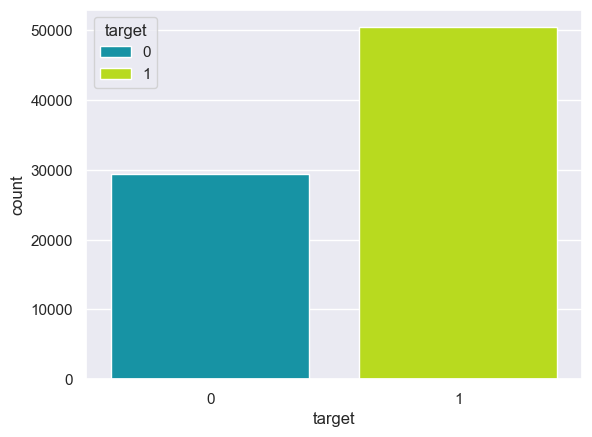

In [31]:
from collections import Counter
from matplotlib import pyplot as plt
import seaborn as sns

# Illustrate the imbalance between classification targets 
print(sorted(Counter(y_train).items()))
sns.set_style('white')
sns.set(font_scale=1)
plt.figure()
sns.countplot(x=y_train, hue=y_train, palette='nipy_spectral')
plt.show()

[(0, 50471), (1, 50471)]


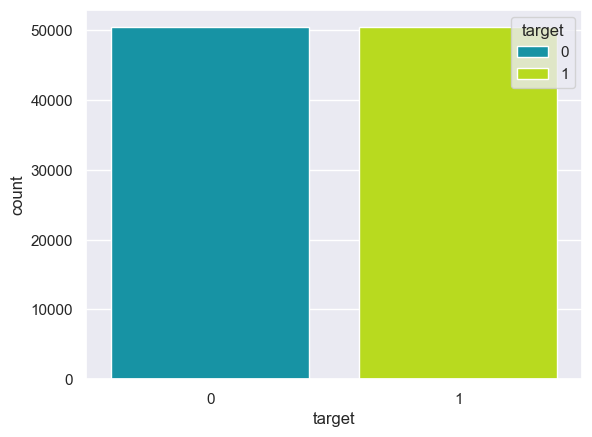

In [32]:
# from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

# Balance targets with Synthetic Minority Oversampling Technique
# smote = SMOTE(random_state=0)
ros = RandomOverSampler()

X_train, y_train = ros.fit_resample(X_train, y_train)

# Illustrate the balance between classification targets 
print(sorted(Counter(y_train).items()))
sns.set_style('white')
sns.set(font_scale=1)
plt.figure()
sns.countplot(x=y_train, hue=y_train,palette='nipy_spectral')
plt.show()

In [33]:
# Print the shape of each part
print("Shapes:")
print("X_train: ", X_train.shape)
print("X_test:  ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test:  ", y_test.shape)

Shapes:
X_train:  (100942, 2)
X_test:   (22000, 2)
y_train:  (100942,)
y_test:   (22000,)


[<a href="#content">Back to top</a>]

## Machine Leraning  <a name="6"></a>

In [34]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

# Instantiate the algorithms that will be used, placing them in a dictionary 
clfs = {"SVM":SVC(kernel='rbf', C=1, probability=True),
        "Decision":DecisionTreeClassifier(), 
        "RandomForest":RandomForestClassifier(), 
        "GradientBoost":GradientBoostingClassifier(),
        "XGBoost":XGBClassifier(verbosity=0),
       "K-nearest": KNeighborsClassifier(n_neighbors=3)
       }

In [35]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

# Create statistics with the results of training with different algorithms
def model_fit(clfs):
    fitted_model={}
    model_result = pd.DataFrame()
    # Iterate the clfs dictionary clfs
    for model_name, model in clfs.items():
        # Train the current model
        model.fit(X_train,y_train)
        # Add the current model name
        fitted_model.update({model_name:model})
        # Prediction of the current model 
        y_pred = model.predict(X_test)
        model_dict = {}
        model_dict['1.Algorithm'] = model_name
        # Calculate the metrics
        model_dict['2.Accuracy'] = round(accuracy_score(y_test, y_pred),3)
        model_dict['3.Precision'] = round(precision_score(y_test, y_pred),3)
        model_dict['4.Recall'] = round(recall_score(y_test, y_pred),3)
        model_dict['5.F1'] = round(f1_score(y_test, y_pred),3)
        model_dict['6.ROC'] = round(roc_auc_score(y_test, y_pred),3)
        model_result = model_result._append(model_dict,ignore_index=True)
    return fitted_model, model_result

# Run the function model_fit(clfs) 
fitted_model, model_result = model_fit(clfs)

# Display the results of the model_fit(clfs) function in a descending order
model_result.sort_values(by=['2.Accuracy'],ascending=False)

,1.Algorithm,2.Accuracy,3.Precision,4.Recall,5.F1,6.ROC
4,XGBoost,0.861,0.934,0.777,0.848,0.861
3,GradientBoost,0.851,0.942,0.749,0.834,0.851
2,RandomForest,0.846,0.855,0.835,0.845,0.846
5,K-nearest,0.834,0.848,0.815,0.831,0.834
1,Decision,0.805,0.776,0.857,0.815,0.805
0,SVM,0.788,0.924,0.627,0.747,0.788


[<a href="#content">Back to top</a>]

## Cross-validation <a name="7"></a>

In [37]:
# Five-fold cross-validation 
import numpy as np 
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline # Important for combining steps

# Print the proportion 
print(f"Original dataset shape: {X_cv.shape}, labels shape: {y_cv.shape}")
print(f"Class distribution (0: Majority, 1: Minority): {np.bincount(y_cv)}\n")

# Define the Model and Cross-Validation Strategy
model = RandomForestClassifier(random_state=42)

# Number of folds
n_splits = 5 

# Stratified K-Fold ensures balanced class distribution in each fold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Lists to store metrics from each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

# Cross-Validation Loop with Resampling
print(f"Performing {n_splits}-Fold Stratified Cross-Validation with RandomOverSAmpler...\n")

for fold, (train_index, test_index) in enumerate(skf.split(X_cv, y_cv)):
    print(f"--- Fold {fold + 1}/{n_splits} ---")

    # Split data for the current fold
    X_train_cv, X_test_cv = X_cv.iloc[train_index], X_cv.iloc[test_index]
    y_train_cv, y_test_cv = y_cv.iloc[train_index], y_cv.iloc[test_index]

    # StratifiedKFold ensures similar distribution in train/test
    print(f"  Training set class distribution: {np.bincount(y_train_cv)}")
    print(f"  Test set class distribution: {np.bincount(y_test_cv)}")

    # Define resampling strategy
    over_sampler_pipeline = Pipeline([
        ('oversample', RandomOverSampler(random_state=42))
    ])
    X_train_resampled, y_train_resampled = over_sampler_pipeline.fit_resample(X_train_cv, y_train_cv)
    print(f"  Training set (after SMOTE) class distribution: {np.bincount(y_train_resampled)}")

    # Train the model on the resampled training data
    model.fit(X_train_resampled, y_train_resampled)

    # Make predictions on the *original, untouched* test data
    y_pred_cv = model.predict(X_test_cv)
    y_prob_cv = model.predict_proba(X_test_cv)[:, 1] # Probability for the positive class (class 1)

    # Evaluate performance for the current fold
    accuracy = accuracy_score(y_test_cv, y_pred_cv)
    precision = precision_score(y_test_cv, y_pred_cv, zero_division=0) # zero_division=0 prevents warning if no true positives
    recall = recall_score(y_test_cv, y_pred_cv, zero_division=0)
    f1 = f1_score(y_test_cv, y_pred_cv, zero_division=0)
    roc_auc = roc_auc_score(y_test_cv, y_prob_cv)

    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)

    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}")
    print(f"  Confusion Matrix:\n{confusion_matrix(y_test_cv, y_pred_cv)}\n")
    # print(classification_report(y_test, y_pred)) # Can print full report per fold
    print("-" * 30)


# Aggregate and Report Final Metrics
print("\n--- Cross-Validation Results Summary ---")
print(f"Average Accuracy: {np.mean(accuracy_scores):.4f} +/- {np.std(accuracy_scores):.4f}")
print(f"Average Precision: {np.mean(precision_scores):.4f} +/- {np.std(precision_scores):.4f}")
print(f"Average Recall: {np.mean(recall_scores):.4f} +/- {np.std(recall_scores):.4f}")
print(f"Average F1-Score: {np.mean(f1_scores):.4f} +/- {np.std(f1_scores):.4f}")
print(f"Average ROC AUC: {np.mean(roc_auc_scores):.4f} +/- {np.std(roc_auc_scores):.4f}")

# Convert lists to NumPy arrays for easier manipulation (e.g., if you want to save them)
all_scores = {
    'accuracy': np.array(accuracy_scores),
    'precision': np.array(precision_scores),
    'recall': np.array(recall_scores),
    'f1_score': np.array(f1_scores),
    'roc_auc': np.array(roc_auc_scores)
}

Original dataset shape: (79876, 2), labels shape: (79876,)
Class distribution (0: Majority, 1: Minority): [29405 50471]

Performing 5-Fold Stratified Cross-Validation with RandomOverSAmpler...

--- Fold 1/5 ---
  Training set class distribution: [23524 40376]
  Test set class distribution: [ 5881 10095]
  Training set (after SMOTE) class distribution: [40376 40376]
  Accuracy: 0.8378
  Precision: 0.9070
  Recall: 0.8281
  F1-Score: 0.8658
  ROC AUC: 0.9105
  Confusion Matrix:
[[5024  857]
 [1735 8360]]

------------------------------
--- Fold 2/5 ---
  Training set class distribution: [23524 40377]
  Test set class distribution: [ 5881 10094]
  Training set (after SMOTE) class distribution: [40377 40377]
  Accuracy: 0.8391
  Precision: 0.9049
  Recall: 0.8329
  F1-Score: 0.8674
  ROC AUC: 0.9110
  Confusion Matrix:
[[4997  884]
 [1687 8407]]

------------------------------
--- Fold 3/5 ---
  Training set class distribution: [23524 40377]
  Test set class distribution: [ 5881 10094]
  T

[<a href="#content">Back to top</a>]

## Scrutinize for overfitting <a name="8"></a>

In [38]:
# Evaluate random forest classifier performance on train and test sets with different tree depths
train_scores, test_scores = list(), list()
# define the tree depths to evaluate
values = [i for i in range(1, 31)]
# evaluate a decision tree for each depth
for i in values:
 # configure the model
 model_ = XGBClassifier(max_depth=i)
 # fit model_ on the training dataset
 model_.fit(X_train, y_train)
 # evaluate on the train dataset
 train_yhat = model_.predict(X_train)
 train_acc = accuracy_score(y_train, train_yhat)
 train_scores.append(train_acc)
 # evaluate on the test dataset
 test_yhat = model_.predict(X_test)
 test_acc = accuracy_score(y_test, test_yhat)
 test_scores.append(test_acc)
 # summarize progress
 print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

>1, train: 0.841, test: 0.838
>2, train: 0.853, test: 0.851
>3, train: 0.859, test: 0.855
>4, train: 0.863, test: 0.858
>5, train: 0.867, test: 0.859
>6, train: 0.870, test: 0.861
>7, train: 0.874, test: 0.862
>8, train: 0.876, test: 0.862
>9, train: 0.879, test: 0.860
>10, train: 0.881, test: 0.861
>11, train: 0.883, test: 0.860
>12, train: 0.885, test: 0.859
>13, train: 0.886, test: 0.857
>14, train: 0.888, test: 0.855
>15, train: 0.889, test: 0.853
>16, train: 0.891, test: 0.852
>17, train: 0.892, test: 0.850
>18, train: 0.893, test: 0.850
>19, train: 0.894, test: 0.848
>20, train: 0.895, test: 0.847
>21, train: 0.895, test: 0.847
>22, train: 0.896, test: 0.845
>23, train: 0.897, test: 0.845
>24, train: 0.897, test: 0.846
>25, train: 0.897, test: 0.845
>26, train: 0.897, test: 0.845
>27, train: 0.898, test: 0.844
>28, train: 0.898, test: 0.843
>29, train: 0.899, test: 0.844
>30, train: 0.899, test: 0.842


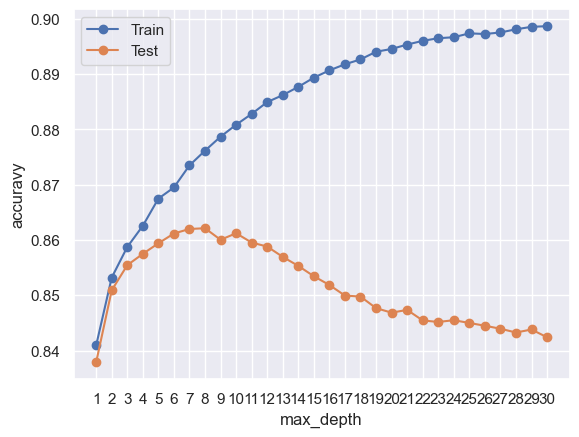

In [39]:
import math
import matplotlib.pyplot as plt

# Set integers for x axis
new_x_ticks = range(math.floor(min(values)), math.ceil(max(values))+1)
plt.xticks(new_x_ticks)
# Plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.xlabel("max_depth")
plt.ylabel("accuravy")
plt.show()

In [40]:
# Instantiate the estimator 
model = XGBClassifier(max_depth=7)

# Train  
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
acc = round(accuracy_score(y_test, y_pred),3)
print('Accuracy: ', acc)
pre = round(precision_score(y_test, y_pred),3)
print('Precision: ', pre) 
rec = round(recall_score(y_test, y_pred),3)
print('Recall: ',rec) 
f1 = round(f1_score(y_test, y_pred),3)
print('F1: ', f1) 
roc = round(roc_auc_score(y_test, y_pred),3) 
print('ROC: ', roc)

Accuracy:  0.859
Precision:  0.938
Recall:  0.769
F1:  0.846
ROC:  0.859


[<a href="#content">Back to top</a>]

##  Hyperparameter tuning with Optuna <a name="8"></a>

In [41]:
# Hyperparameter tuning with optuna
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    """
    Objective function for Optuna hyperparameter optimization.

    Args:
        trial: An Optuna trial object.

    Returns:
        The negative accuracy score (to be minimized).
    """
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-3, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }

    model = XGBClassifier(**params)
    accuracy = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    return -accuracy  # Optuna minimizes the objective function

# Create a study object
study = optuna.create_study(direction='minimize') 

# Run the optimization
study.optimize(objective, n_trials=100)  # Adjust n_trials as needed

# Get the best hyperparameters
best_params = study.best_params

# Train the model with the best hyperparameters
best_model = XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred) 
print(f"Best Accuracy: {accuracy}")
print(f"Best Hyperparameters: {best_params}")

[I 2025-07-18 01:23:26,605] A new study created in memory with name: no-name-b14c41c6-97c1-402c-9565-bf97b65dfeb4
[I 2025-07-18 01:23:31,535] Trial 0 finished with value: -0.8364010575590685 and parameters: {'max_depth': 5, 'learning_rate': 0.005909738884081262, 'n_estimators': 357, 'subsample': 0.5901494408880699, 'colsample_bytree': 0.750181728492159, 'gamma': 0.2885372462188898, 'reg_lambda': 0.0018597450664412237, 'min_child_weight': 9}. Best is trial 0 with value: -0.8364010575590685.
[I 2025-07-18 01:23:36,367] Trial 1 finished with value: -0.8459015729138519 and parameters: {'max_depth': 7, 'learning_rate': 0.003460987483171485, 'n_estimators': 282, 'subsample': 0.7715444624589975, 'colsample_bytree': 0.5832112384015652, 'gamma': 0.22881843312219843, 'reg_lambda': 0.0017436207182153422, 'min_child_weight': 5}. Best is trial 1 with value: -0.8459015729138519.
[I 2025-07-18 01:23:40,302] Trial 2 finished with value: -0.8351131932031681 and parameters: {'max_depth': 5, 'learning_ra

Best Accuracy: 0.856
Best Hyperparameters: {'max_depth': 10, 'learning_rate': 0.09790379061533522, 'n_estimators': 381, 'subsample': 0.9643287011295956, 'colsample_bytree': 0.6768313198320017, 'gamma': 0.4118816197620953, 'reg_lambda': 0.22788987566223684, 'min_child_weight': 6}


[<a href="#content">Back to top</a>]

## Confusion matrix and classification report  <a name="9"></a>

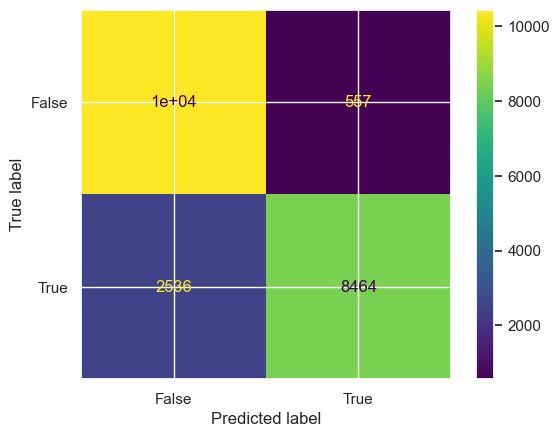

In [42]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# Random forest classifier prediction
predicted = XGBClassifier(max_depth=7).fit(X_train,y_train).predict(X_test)

# Calculate the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, predicted)

# Display confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [43]:
from sklearn.metrics import classification_report

# Print the classification report 
target_names = ['Active (target 1) ', 'Inactive (target 0)']
print(classification_report(y_test, predicted, target_names=target_names))

                     precision    recall  f1-score   support

 Active (target 1)        0.80      0.95      0.87     11000
Inactive (target 0)       0.94      0.77      0.85     11000

           accuracy                           0.86     22000
          macro avg       0.87      0.86      0.86     22000
       weighted avg       0.87      0.86      0.86     22000



[<a href="#content">Back to top</a>]